In [17]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import os
from SSMs import SSM
from os.path import dirname, join as pjoin
import torch
print(torch.cuda.is_available())
from torch import nn
import time

dtype = torch.float
device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch.cuda.is_available())

plt.close('all')
# Import Data
folderpath = os.getcwd()
filepath = pjoin(folderpath, 'input_3.mat')#'dataset_sysID_3tanks.mat')
data_in = scipy.io.loadmat(filepath)
filepath = pjoin(folderpath, 'output_Q_3.mat')
data_out = scipy.io.loadmat(filepath)
filepath = pjoin(folderpath, 'subsystems.mat')
data_sub = scipy.io.loadmat(filepath)

filepath = pjoin(folderpath, 'denormalize.mat')
data_max = scipy.io.loadmat(filepath)

# Extract data from dictionary
maxTrit, maxTdel = data_max['maxTrit'], data_max['maxTman']
Toutass_t, Toutass_v, Toutchill_t, Toutchill_v = data_sub['Toutass_train'], data_sub['Toutass_val'], data_sub['Toutchillers_train'], data_sub['Toutchillers_val']
dExp, yExp, dExp_val, yExp_val, time__, buildtot, buildtot_val = data_in['dExp'], data_out['yExp'], \
    data_in['dExp_val'], data_out['yExp_val'], data_in['time__'], data_out['buildtotnorm'], data_out['buildtotnorm_val']
nExp = yExp.size

t = time__

t_end = t.size

False
False


In [36]:
# Initialize input and output tensors
u_users = torch.zeros(nExp, t_end, 2) 
y_train_users = torch.zeros(nExp, t_end, 1)
u_abs = torch.zeros(nExp, t_end, 2) 
y_train_abs = torch.zeros(nExp, t_end, 1)
u_chill = torch.zeros(nExp, t_end, 2)
y_train_chill = torch.zeros(nExp, t_end, 1)

# Fill input and output tensors with data
for j in range(nExp):
    u_users[j, :, :] = torch.cat(
    (
        torch.from_numpy(buildtot[j * t_end: (j + 1) * t_end, 0]).unsqueeze(1),  # Q_users
        torch.from_numpy(yExp[0, j][:, 1]).unsqueeze(1)    # Tman
    ),
    dim=-1
)
   
    y_train_users[j, :, :] = (torch.from_numpy(yExp[0, j][:,0]).unsqueeze(1) ) #Trit
    
    u_abs[j, :, :] = torch.cat(
    (
        torch.from_numpy(dExp[0,j][:,-1]).unsqueeze(1),  # Q_abs
        torch.from_numpy(yExp[0, j][:, 0]).unsqueeze(1)    # Trit
    ),
    dim=-1
)
   
    y_train_abs[j, :, :] = (torch.from_numpy(yExp[0, j][:,1]).unsqueeze(1) ) #Tman
    
    u_chill[j, :, :] = torch.cat(
    (
        torch.from_numpy(dExp[0,j][:,-2]).unsqueeze(1),  # I/O
        torch.from_numpy(yExp[0, j][:, 0]).unsqueeze(1)    # Trit
    ),
    dim=-1
)
   
    y_train_chill[j, :, :] = (torch.from_numpy(yExp[0, j][:,1]).unsqueeze(1) ) #Tman
    
    
seed = 55
torch.manual_seed(seed)

In [37]:
hdd = 150

SSMumodel = (SSM
       (#N=3,
        in_features=2,
        out_features=1,
        #mid_features=21,
        state_features=hdd,
        scan = True,
        ))
SSMamodel = (SSM
       (#N=3,
        in_features=2,
        out_features=1,
        #mid_features=21,
        state_features=hdd,
        scan = True,
        ))
SSMcmodel = (SSM
       (#N=3,
        in_features=2,
        out_features=1,
        #mid_features=21,
        state_features=hdd,
        scan = True,
        ))

#total_params = sum(p.numel() for p in SSM.parameters())
#print(f"Number of parameters: {total_params}")

#RNN = torch.jit.script(RNN)

MSE = nn.MSELoss()

# Define Optimization method
learning_rate = 1.0e-2
optimizer = torch.optim.Adam([
                {'params': SSMumodel.parameters()}, {'params': SSMcmodel.parameters()},
                {'params': SSMamodel.parameters()}], lr=learning_rate)
optimizer.zero_grad()

t_end = yExp[0, 0].shape[0]

epochs = 300
LOSS = np.zeros(epochs)


In [38]:

t0= time.time()
for epoch in range(epochs):
    if epoch == epochs - epochs / 2:
        learning_rate = 1.0e-3
        optimizer = torch.optim.Adam([
                {'params': SSMumodel.parameters()}, {'params': SSMcmodel.parameters()},
                {'params': SSMamodel.parameters()}], lr=learning_rate) 
    if epoch == epochs - epochs / 6:
        learning_rate = 1.0e-4
        optimizer = torch.optim.Adam([
                {'params': SSMumodel.parameters()}, {'params': SSMcmodel.parameters()},
                {'params': SSMamodel.parameters()}], lr=learning_rate) 
    optimizer.zero_grad()
    loss = 0
    ####users
    yusers = SSMumodel(u_users)
    ####absorber
    yabs = SSMamodel(u_abs)
    ####chillers
    ychill = SSMcmodel(u_chill)
    
    #loss backpropagate
    loss = MSE(yusers, y_train_users) + MSE(yabs, y_train_abs) + MSE(ychill, y_train_chill)
    print(f"Epoch: {epoch + 1} \t||\t Loss: {loss}")
    loss.backward(retain_graph=True)
    optimizer.step()
    
    LOSS[epoch] = loss.item()

    # rewrite the inputs with the outputs of the SSM models
    u_users = torch.cat(
        [
            u_users[:, :, :-1], 
            ((yabs * 300 + 
            ychill * 300 * u_chill[:, :, :-1] * 3 + 
            yusers * (1200 - 300 * (1 + u_chill[:, :, :-1] * 3))
            ) / 1200).detach().clone()
        ],
        dim=2
    )
    u_abs = torch.cat((u_abs[:, :, :-1], yusers.detach().clone()), dim=2)
    u_chill = torch.cat((u_chill[:, :, :-1], yusers.detach().clone()), dim=2)

    
t1= time.time()

total_time= t1-t0

Epoch: 1 	||	 Loss: 1.2015068531036377
torch.Size([4, 30240, 1])
Epoch: 2 	||	 Loss: 0.9306138753890991
torch.Size([4, 30240, 1])
Epoch: 3 	||	 Loss: 0.7526693344116211
torch.Size([4, 30240, 1])
Epoch: 4 	||	 Loss: 0.5304033160209656
torch.Size([4, 30240, 1])
Epoch: 5 	||	 Loss: 0.406898558139801
torch.Size([4, 30240, 1])
Epoch: 6 	||	 Loss: 0.6322813630104065
torch.Size([4, 30240, 1])
Epoch: 7 	||	 Loss: 0.6278814077377319
torch.Size([4, 30240, 1])
Epoch: 8 	||	 Loss: 0.3947741389274597
torch.Size([4, 30240, 1])
Epoch: 9 	||	 Loss: 0.4215409755706787
torch.Size([4, 30240, 1])
Epoch: 10 	||	 Loss: 0.18347857892513275
torch.Size([4, 30240, 1])
Epoch: 11 	||	 Loss: 0.17938090860843658
torch.Size([4, 30240, 1])
Epoch: 12 	||	 Loss: 0.24314653873443604
torch.Size([4, 30240, 1])
Epoch: 13 	||	 Loss: 0.28911274671554565
torch.Size([4, 30240, 1])
Epoch: 14 	||	 Loss: 0.29592886567115784
torch.Size([4, 30240, 1])
Epoch: 15 	||	 Loss: 0.2251925766468048
torch.Size([4, 30240, 1])
Epoch: 16 	||	 

In [39]:
#same for each models
nExp = yExp_val.size
t_end = yExp_val[0,0].shape[0]
uval_u = torch.zeros(nExp, t_end, 2)
yval_u = torch.zeros(nExp, t_end, 1)

uval_a = torch.zeros(nExp, t_end, 2)
yval_a = torch.zeros(nExp, t_end, 1)

uval_c = torch.zeros(nExp, t_end, 2)
yval_c = torch.zeros(nExp, t_end, 1)

# Tman as initilalization
for j in range(nExp):
    uval_u[j, :, :] = torch.cat(
    (
        torch.from_numpy(buildtot_val[j * t_end: (j + 1) * t_end, 0]).unsqueeze(1),  # Q_users
        torch.from_numpy(yExp_val[0, j][:, 1]).unsqueeze(1)    # Tman
    ),
    dim=-1
)
   
    yval_u[j, :, :] = (torch.from_numpy(yExp_val[0, j][:,0]).unsqueeze(1) ) #Trit
    
yuser_val = SSMamodel(uval_a)
yuser_val = torch.squeeze(yuser_val)
yval_u = torch.squeeze(yval_u)
    
for j in range(nExp):    
    ##############absorber
    uval_a[j, :, :] = torch.cat(
    (
        torch.from_numpy(dExp_val[0,j][:,-1]).unsqueeze(1),  #Qabs
        #torch.from_numpy(dExp_val[0, j][:, 0]).unsqueeze(1),   # Text
        yuser_val[:].unsqueeze(1)   # Trit
    ),
    dim=-1
)
   
    yval_a[j, :, :] = torch.from_numpy(Toutass_v[j * t_end: (j + 1) * t_end, 0]).unsqueeze(1) #Toutabs
    
    uval_c[j, :, :] = torch.cat(
    (
        torch.from_numpy(dExp_val[0,j][:,-2]).unsqueeze(1),  #I/O
        #torch.from_numpy(dExp_val[0, j][:, 0]).unsqueeze(),   # Text
        yuser_val[:].unsqueeze(1)    # Trit
    ),
    dim=-1
)
   
    yval_c[j, :, :] = torch.from_numpy(Toutchill_v[j * t_end: (j + 1) * t_end, 0]).unsqueeze(1) #Toutchill
 
 
yabs_val = SSMamodel(uval_a)
yabs_val = torch.squeeze(yabs_val)
yval_a = torch.squeeze(yval_a)

ychill_val = SSMcmodel(uval_c)
ychill_val = torch.squeeze(ychill_val)
yval_c = torch.squeeze(yval_c)

loss_val = MSE(yuser_val, yval_u) + MSE(yabs_val, yval_a) + MSE(ychill_val, yval_c)

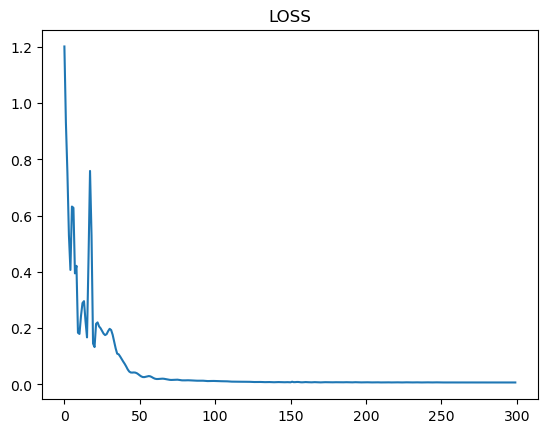

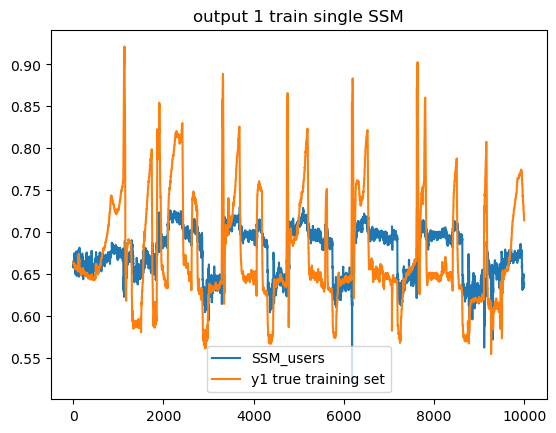

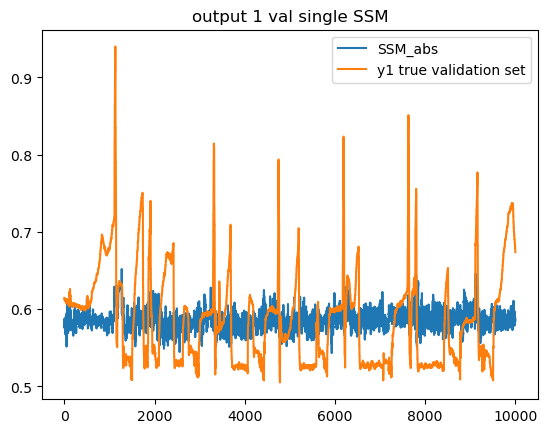

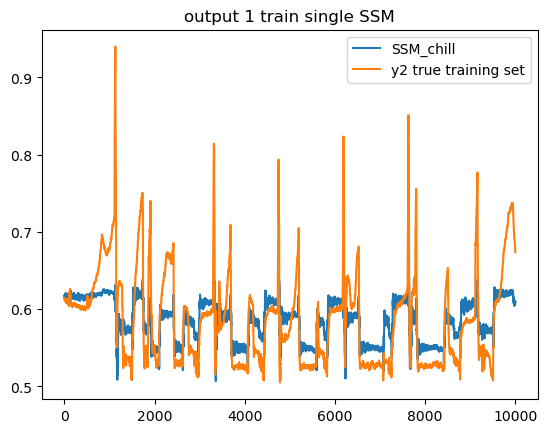

In [40]:
plt.figure('8')
plt.plot(LOSS)
plt.title("LOSS")
plt.show()

plt.figure('9')
plt.plot(yusers[0, 10000:20000, 0].cpu().detach().numpy(), label='SSM_users')
plt.plot(y_train_users[0, 10000:20000, 0].cpu().detach().numpy(), label='y1 true training set')
plt.title("output 1 train single SSM")
plt.legend()
plt.show()

plt.figure('10')
plt.plot(yabs[0, 10000:20000, 0].cpu().detach().numpy(), label='SSM_abs')
plt.plot(y_train_abs[0, 10000:20000, 0].cpu().detach().numpy(), label='y1 true validation set')
plt.title("output 1 val single SSM")
plt.legend()
plt.show()

plt.figure('11')
plt.plot(ychill[0, 10000:20000, 0].cpu().detach().numpy(), label='SSM_chill')
plt.plot(y_train_chill[0, 10000:20000, 0].cpu().detach().numpy(), label='y2 true training set')
plt.title("output 1 train single SSM")
plt.legend()
plt.show()

# plt.figure('15')
# plt.plot(d[inputnumberD, :].detach().numpy(), label='input train')
# plt.plot(dval[inputnumberD, :].detach().numpy(), label='input val')
# plt.title("input single REN")
# plt.legend()
# plt.show()

#print(f"Loss Validation single RNN: {loss_val}")